# Matched Filtering

Now that a rigorous method of cutting the FFT is in place. It makes sense to move on to a more performant option, matched filtering.

We can use the convolution theorem to provide a matched filter test statistic: 

$$ \mathcal{T} = \text{max m} \left| \sum^{N_{bin}}_{n=0} h^{\dagger}_{m} [n] y[n]      \right|$$

Where $h^{\dagger}_{m}[n]$ is the complex conjugate of the m-th signal template, $y[n]$ is the frequency spectrum of the time series, and $N_{bin}$ is the number of bins in the spectrum.

For a single spectrum we have

$$ \mathcal{T} =  \left| \sum^{N_{bin}}_{n=0} h^{\dagger} [n] y[n]      \right|$$

Through length derivation, we can arrive at an exact form of the matched filter score PDF

$$ P_1(w;\mathcal{T_0}) = 2w \text{exp} \left( - \left( w^2 - \mathcal{T_0}^2 \right)\right) I_0 (2w\mathcal{T_0}) $$

where $I_0$ is the modified Bessel function of the first kind of order 0, $w$ is the matched filter score decision threshold.

If we consider that the shape of the matched filter score distribution is related to the paramter $\mathcal{T_0}$, which is the value of the matched filter score if no noise is present. Without noise the data vector reduces to the signal $\bf{x}$. So the matched filter test statistic then can simply become an inner product. This can be represented in terms of the magnitudes of the vectors and a constant that describes the degree of orthogonality between the vectors.

From the Cauchy-Schwarz inequality, we know that the inner product of two vectors is less than or equal to the product of the magnitudes of the vectors. This can be written as

$$ \mathcal{T}_0 =  \left|  h^{\dagger} \cdot \bf{x}    \right| = | h^{\dagger} | | \bf{x} | \Gamma $$

Where $\Gamma$ is a number that ranges from 0 to 1 and describes the orthogonality between $\bf{x}$ and $h^{\dagger}$. The value of $\Gamma$ is 1 when the vectors are perfectly aligned and 0 when they are orthogonal.

The $\mathcal{H}_0$ PDF can be obtained by setting $\mathcal{T}_0 = 0$ in the matched filter score PDF. This gives a Rayleigh distribution.

$$ P_0(w) = 2w  \text{ exp} \left( -w^2 \right) $$

Single template scenario is all good, but a PDF that describes the MF test statistic in the presence of multiple templates (a template bank) is not going to work, since there is no guarantee of orthogonality between MF templates. It must be therefore assumed that the MF scores for all templates are IID variables. The effect of this is to underestimate the performance by over-estimating the required number of templates and magnitude of teh statistical trials penalty.

This magnitude of underestimation may be quantified using MC testing of the MF templates and randomly generated test signals.

The probability that the MF score falls below a decision threshold under the null hypothesis is given by

$$ F_0(w) = \int^{w}_{0} P_0(w) dw = 1 - \text{exp} \left( -w^2 \right) $$

The CDF, however, that describes $\mathcal{H}_1$ is derived by starting with the CDF of the best matching template. If we take this, which should yield the largest MF score, which is defined by 

$$ \mathcal{T}_{best} = \text{max m} \left| h^{\dagger}_{m} \cdot \bf{x} \Gamma_{m} \right| = |\bf{h}_{best}||\bf{x}|\Gamma_{best} $$

where $\bf{h}_{best}$ is the best matching template, $\Gamma_{best}$ is the orthogonality between the best matching template and the signal. 

A key performance parameter for the template bank is the mean value of $\mathcal{T}_{best}$ over the parameter space covered by the template bank. A higher density of templates will result in a higher $\Gamma_{best}$ and better detection efficiency.

The CDF under $\mathcal{H}_1$ is the join distribution between the best matching template CDF and the CDFs of all the otehr templates. The orthogonality assumption described above, the MF scores for all other templates are treated as negligble ($\mathcal{T}_{0} \approx 0$). The CDF under $\mathcal{H}_1$ is then given by

$$ F_1(w;\mathcal{T}_{best}) = F_{best}(w;\mathcal{T}_best) \left( 1 - e^{-w^{2}} \right)^{N_t} $$

where $N$ is the number of templates in the bank.

So given all of this, we have both of the CDFs required to get this going, so let us go. 

In [8]:
import sys
sys.path.append("../")

from __init__ import *
from data_tools import *
from testing import *
from analysis import *


import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'


R, Nch, kb, bw, Nsamp, T= 496.1709043911709, 1, 1.38e-23, 1000e6, 40960, 5

n_pwr = kb * T * bw # noise power
tau_1t = n_pwr * R # noise variance single channel, time-domain (tau_1t)
tau_1f = tau_1t / Nsamp # noise variance single channel, freq-domain (tau_1f)

def F0(w, N_t):
    return (1 - np.exp(- (w**2)))**N_t

def F1(w, N_t, T_best, tau):
    
    sigma = np.sqrt(tau/2)
    print(sigma)
    
    nu = T_best / sigma  # Non-centrality parameter
    
    print(nu)
    
    return scipy.stats.rice.cdf(w, b=nu, loc=0, scale=sigma) * F0(w, N_t)


In [9]:
np.sqrt(tau_1f)

# array with 40960 samples all at 1e-8

arr = np.ones(Nsamp) * 1e-7
arr_1 = np.ones(Nsamp) * 1e-7



best_score = np.linalg.norm(arr) ** 2 

print(best_score)

4.0960000000009746e-10


In [10]:
x = np.linspace(0, 12, 2001)

N_t = 50 # number of templates

ideal_cdf = scipy.stats.rice.cdf(
    x,
    mean_score,
    loc = mean_score * (1 - 1 / np.sqrt(2)),
    scale=1/np.sqrt(2)
)


F0_cdf = F0(x, N_t)
H0_pdf = np.gradient(F0_cdf, x)

real_pdf = ideal_cdf * F0(x, N_t)

H1_pdf = np.gradient(real_pdf, x)




# F1_cdf = F1(x, 10, 4.095999999999093e90, tau_1f)
# H1_pdf = np.gradient(F1_cdf, x)

# test_CDF = F1(x, 40960, 1, 10)
# test_pdf = np.gradient(test_CDF, x)

plt.plot(x, H0_pdf)
plt.plot(x, H1_pdf, '--', label='H1')
# plt.plot(x, test_pdf, '-.')
plt.legend()
plt.show()

np.trapz(H0_pdf, x), np.trapz(H1_pdf, x)

NameError: name 'mean_score' is not defined

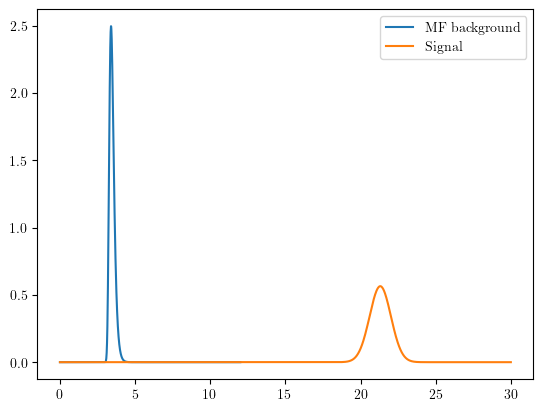

In [67]:
x_1 = np.linspace(0, 12, 1001)
mf_background_cdf = scipy.stats.rayleigh.cdf(x_1, loc=0, scale=(1/np.sqrt(2))) ** (1e5 / 1)
mf_background_pdf = np.gradient(mf_background_cdf)
mf_background_pdf = mf_background_pdf / np.trapz(mf_background_pdf, x_1)

N_template=1e8
n_pts = 1001

best_score = 21.2944254600051


x = np.linspace(0, 30, n_pts)
ideal_cdf = scipy.stats.rice.cdf(
        x,
        best_score,
        loc = best_score * (1 - 1 / np.sqrt(2)),
        scale=1/np.sqrt(2)
    )
noise_cdf = scipy.stats.rayleigh.cdf(x, loc=0, scale=(1/np.sqrt(2))) ** ((N_template-1)/1)
signal_cdf = noise_cdf * ideal_cdf

signal_pdf = np.gradient(signal_cdf)
signal_pdf = signal_pdf / np.trapz(signal_pdf, x)

plt.plot(x_1, mf_background_pdf, label='MF background')
plt.plot(x, signal_pdf, label='Signal')
plt.legend()
plt.show()


In [85]:
N = 1000
scale_factor = tau_1f


file_ = 'harmonic/86p5deg/out_0aa72c89-416e-4f11-8eda-ae7542078817.h5'
signal_strings, attributes, attrs_container = get_attributes(file_)
signal = get_signal(file_, 'signal1') # One polarisation
signal_FFT = np.fft.fft(signal, norm='forward')

signal_FFT = np.abs(signal_FFT)

template = np.abs(signal_FFT) * (1/np.sqrt(scale_factor)) 
template /= np.linalg.norm(signal_FFT)

best_score = np.linalg.norm(signal_FFT) * np.linalg.norm(template)

print(best_score)

6.526013401764524


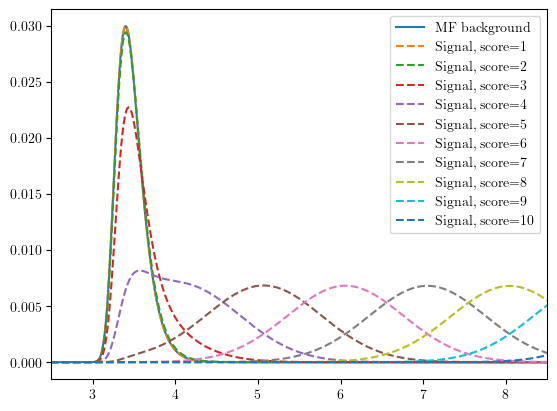

array([0.        , 0.        , 0.        , ..., 0.00015451, 0.00014743,
       0.00014396])

In [83]:
N_template=1e5
n_pts = 1001

x_1 = np.linspace(0, 12, n_pts)
mf_background_cdf = scipy.stats.rayleigh.cdf(x_1, loc=0, scale=(1/np.sqrt(2))) ** (N_template / 1)
mf_background_pdf = np.gradient(mf_background_cdf)
# mf_background_pdf = mf_background_pdf / np.trapz(mf_background_pdf, x_1)

plt.plot(x_1, mf_background_pdf, label='MF background')


scores = [1,2,3,4,5,6,7,8,9,10]

for best_score in scores:

    ideal_cdf = scipy.stats.rice.cdf(
            x_1,
            best_score,
            loc = best_score * (1 - 1 / np.sqrt(2)),
            scale=1/np.sqrt(2)
        )
    noise_cdf = scipy.stats.rayleigh.cdf(x_1, loc=0, scale=(1/np.sqrt(2))) ** ((N_template-1)/1)
    signal_cdf = noise_cdf * ideal_cdf

    signal_pdf = np.gradient(signal_cdf)
# signal_pdf = signal_pdf / np.trapz(signal_pdf, x)

    score_label = f'Signal, score={best_score}'
    
    plt.plot(x_1, signal_pdf, label=score_label, ls='--')
plt.legend()
plt.xlim(2.5,8.5)
plt.show()

signal_pdf

[]
7.020289308862493
[]
7.1165416913730475
[]
7.149044716301814
[]
7.165548896660486
[]
7.0332669585499845
[]
6.976650414747939
[]
7.213750758247288
[]
7.156564927661982


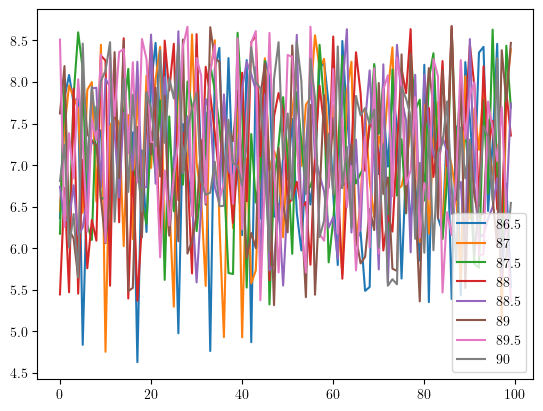

In [96]:
file_list = [
'../../../../Desktop/v2/Harmonic/90.0deg/out_4976c7bd-743b-49a2-99e4-3f13129d44f6.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_7e6aa318-da4b-44df-9c7a-1d3aa145ec95.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_0f1b9486-39d3-4506-9d25-26124797daaa.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_2b704f91-eef3-40eb-b3f7-66018ec408f5.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_97f6e7b8-4717-4e22-ad4c-4a36756fd2c2.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_7aa3c359-e65f-4d3b-ac30-8939462c00a9.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_31cae1d9-c62c-403d-93f0-2e2a81c79948.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_fccfefa1-82b4-4bf2-9e75-0a792badcf32.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_9da4ab31-7923-4dd5-ac10-43fc72270166.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_c61fe326-c0c5-40fb-bf91-788e3e80c458.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_2e1fad5f-7d9b-4757-a091-7d663bb39524.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_64f1d04b-5c61-43d0-a607-f72ccb2e73a2.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_c16e4ef7-898d-4009-9c90-4a1e1a5fc9ae.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_4367ae67-ba83-4078-8355-7723e6e4821f.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_b469c180-2cd1-4b37-a54a-be83169943ae.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_c480765c-e305-41ea-aed6-d538b7e690aa.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_3e5ebbd2-24dd-4f9c-90a9-3ba3c702d90d.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_824ed15d-adc1-4f40-8943-d1311f5ba7c6.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_87cd4a49-7c12-445b-b011-7187c11b9ee2.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_bce80511-e97f-4d3d-bf99-f8b6ea167bd4.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_c766371f-ad7d-4a62-addd-be6e40c2a243.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_e972e1bc-9ac3-4eed-b55f-1c35fee82ac9.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_910fe731-5fc4-4e94-9bc2-c393f923c3f0.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_e15ae87e-e64f-418b-9020-87f4736859d5.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_253c37b8-5eec-4b31-8941-f9dfe65b66b9.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_ba989b18-bffb-4d10-8d35-1926056f591c.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_a3140f60-9be3-498c-94a2-b764dbde8319.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_00f44594-6adf-4caf-84de-6332610be600.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_efc50672-ca98-4b66-aa88-45e739fe79c6.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_36273bb0-9fc4-4da4-b55a-fc1f10d0a337.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_44635470-41c6-447d-9942-5acd31adc379.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_59a76ef7-c006-4183-8eac-ab566f96a2f1.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_c6e4a978-e271-40e2-81bd-f536f89e9a9c.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_95df0dbf-a699-412f-9454-f8fc485b9024.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_19977e8d-ae73-4700-a03f-0de6bd2cc89f.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_e12f6407-8832-48c6-88f3-65c1ae8bfb12.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_b05965cb-7182-4e9b-83b0-bfa331054eba.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_769d36b2-799d-4fc7-81a6-1be603f249f8.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_01a8030e-acff-4668-8b46-67867bd1814f.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_248b3cd5-f36e-4a61-8ae2-c992f39edb8a.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_03e7dbcb-ce57-4203-b077-5494bc465bae.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_2b20d0da-78d1-40c1-9e33-7dbe5790a786.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_1e6fcd43-01fc-44fe-92a8-979e1e9270e8.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_dd97cee0-89dc-4ca3-a1e5-63718c3d90e1.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_8e178af9-fd43-459e-971a-947633956ae8.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_d031acb9-2947-4b03-9f5b-30f70d48c272.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_52606c3f-200b-4323-936d-67a4caa0e46a.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_066f6056-9088-4d62-b400-0e7fe41c2347.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_343dc873-bc13-4375-8d88-f2129cde0fd6.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_1b281597-d5b7-437b-a962-d83840dbd1c3.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_ef4b5ef2-ff7b-436c-9b85-6bfbd1625cb9.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_908b0f71-7f23-473d-bbe1-b902d186cfab.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_1024c43d-0726-40c6-8b59-2e104179f890.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_65bf1bb3-c20e-4154-b1be-eb4ff047ef2a.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_20672790-50e0-4caf-9b8a-4d7a8ecec689.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_a1992805-291e-47af-aee9-bf78bf4e82f4.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_2e1cf92a-28b9-42a7-8a6d-908877350029.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_2ec4d533-d57b-47f6-aae1-4b9a71b70add.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_7c83e67d-f2d8-46a9-8750-bd8106d5f793.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_038a1490-acb4-491b-b7b0-0b34a11efae5.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_0b304bfe-52e5-433a-aca6-eecceb062e3d.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_7aaaf9b9-6359-483a-a667-cff400d8818a.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_a25d5b5c-27ca-4f0b-b87b-a6df3d60e921.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_db4d4df5-8ad7-4b56-b582-d4205c815d9f.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_817d3695-b121-4d9a-9298-7dbb3aa08f00.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_623bc6eb-a17c-436c-8788-cddbf2b51f15.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_0a5a3368-a72b-4392-9ccd-bbcaf9762cbd.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_7d859207-6c74-4136-97c1-bb24ce27314e.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_b572bae6-be18-4b0d-b435-53fa5a18a504.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_ed4c05ba-53aa-4a5f-8acc-0509cd4b5c33.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_3a22b1be-71ac-4be2-982f-fc7284e63af7.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_62bea76b-f0e7-4665-aece-3a526b75af86.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_6af1ca6d-429d-4d40-a516-a6576447a9f3.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_db8ba722-e7fc-4c01-a946-6614dc7c7f3a.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_81bd2326-0f4c-4b5e-a5a3-0a726dda9164.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_38e6c2b1-f9c7-42b7-aa41-6356f0dc584b.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_bf3e06a8-fc30-480c-ade8-514613d91a7b.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_08070d92-7fea-406e-9113-f426d7b090f9.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_54efc53b-5e2b-4e15-97b9-1d37f7ba3b2f.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_aaa77266-bb87-4818-94db-ffed45934bf5.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_45dbdb0d-96cc-49ba-86e5-6f10c0a0ef93.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_23be6e49-7cc3-4a30-9be6-3981288718da.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_72298236-d401-446c-b9a9-57e3d0499600.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_b5a849d1-d916-462d-8f63-3e961ff2ad36.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_f6545dca-6fec-4731-9910-9a399fdfa0b7.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_836b833e-e006-42ba-8b84-dacec198c5f8.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_9222faeb-7fa5-44bb-86fb-70cf4e24c6f3.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_cfd13204-dbe2-48e6-95ac-fc5559e9ef16.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_4e9a34a0-ee82-4b2b-9c82-8335efc9ddd1.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_3435a2ca-3838-4c05-a6bf-6ad35914e2f4.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_d0d02c67-40ee-4fb6-b617-11f23dfc416a.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_8f1cbcb4-8f26-48e0-913e-ff4d8a472cf4.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_e6ea6e56-e614-401a-8f1f-21ba01770f57.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_d79fdbf4-2296-459d-a6ab-33b7f4f55802.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_e7be17e7-e5f5-44e1-a373-a2ef3e7415a3.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_c3b2568f-3993-4d74-8858-84da6e2f5c80.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_cbc1f3f7-62cf-45df-be5b-98467de7b3ab.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_d5d678ac-7b14-4932-bd84-32bc537f3c1b.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_ccbfe2cd-391d-4302-96f7-89b2f868f4e8.h5',
'../../../../Desktop/v2/Harmonic/90.0deg/out_fc91389b-30ee-4597-aa86-76a4887fcb72.h5']

labels = ['86.5', '87', '87.5', '88', '88.5', '89', '89.5', '90']

prefix ='../../../../Desktop/v2/Harmonic/'

suffixes = ['86.5deg/*.h5', '87.0deg/*.h5', '87.5deg/*.h5',
            '88.0deg/*.h5', '88.5deg/*.h5', '89.0deg/*.h5',
            '89.5deg/*.h5', '90.0deg/*.h5']

for j in range(len(labels)):


    path_to_files = prefix + suffixes[j]

    file_list_temp = glob.glob(path_to_files)

    scores = []
    print(scores)

    for file_ in file_list_temp:
        
        # signal_strings, attributes, attrs_container = get_attributes(file_)
        signal = get_signal(file_, 'signal1') # One polarisation
        signal_FFT = np.fft.fft(signal, norm='forward')
        
        
        
        # Creating a perfect normalised template
        
        template = np.copy(signal_FFT)
        template /= np.linalg.norm(signal_FFT)
        template /= np.sqrt(tau_1f)
        
        temp_score = np.linalg.norm(signal_FFT) * np.linalg.norm(template)
        
        
        scores.append(temp_score)
    
    
    print(np.mean(scores))
    
    plt.plot(scores, label=labels[j])
plt.legend()
plt.show()

['../../../../Desktop/v2/Harmonic/86.5deg/out_1d62bf9e-c72a-4369-8bcc-a6e318f56b01.h5',
 '../../../../Desktop/v2/Harmonic/86.5deg/out_4a1a4c8b-4f36-4619-82d7-6593124c760c.h5',
 '../../../../Desktop/v2/Harmonic/86.5deg/out_0b9f96cd-ae99-447c-a214-fd3ba6c943e0.h5',
 '../../../../Desktop/v2/Harmonic/86.5deg/out_e14c809e-0f4d-46a0-adcb-52899fdee6db.h5',
 '../../../../Desktop/v2/Harmonic/86.5deg/out_e6d36e15-59c9-4435-ac97-9a7cd8c03f20.h5',
 '../../../../Desktop/v2/Harmonic/86.5deg/out_0b6c8055-81a6-4f83-af2e-e85a8657f087.h5',
 '../../../../Desktop/v2/Harmonic/86.5deg/out_72f507a7-b7d0-4a9c-b340-a7f6965729a7.h5',
 '../../../../Desktop/v2/Harmonic/86.5deg/out_52e43fbb-f240-4dff-87ed-a6e9a65f09f8.h5',
 '../../../../Desktop/v2/Harmonic/86.5deg/out_fc859790-8048-488f-a163-865392c355be.h5',
 '../../../../Desktop/v2/Harmonic/86.5deg/out_e93c2cb2-65d1-4104-b23d-58a94fcfd00f.h5',
 '../../../../Desktop/v2/Harmonic/86.5deg/out_2d7af7a4-c23b-4ad5-a507-a69aface5208.h5',
 '../../../../Desktop/v2/Harmoni